<a href="https://colab.research.google.com/github/mohitraosatya/bee-forage-adaptive-noise-3sat/blob/main/Bee%E2%80%91Forage_Adaptive_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline  mean: 371.85/400
Bee‑Forage mean: 373.48/400
Δ = 1.62 clauses   p = 0.000732


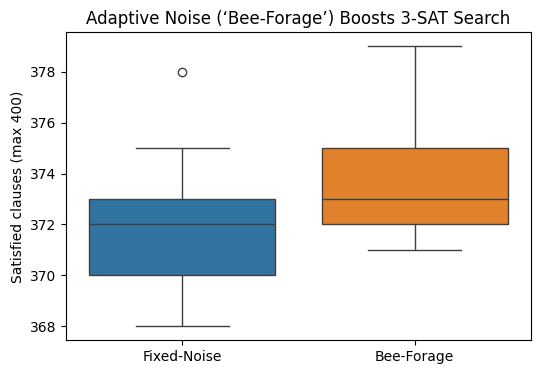

In [4]:
# Bee‑Forage Adaptive‑Noise Demo
import random, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from typing import List, Tuple
from scipy.stats import ttest_ind

# ── PARAMETERS ───────────────────────────────────────────
N_VARS            = 40    # boolean variables
CLAUSE_MULTIPLIER = 10     # clauses = mult × N_VARS ( ↑ = harder )
STEPS             = 5000  # iterations per run
RUNS              = 40    # independent runs

SIGMA_MIN         = 0.02  # exploitation noise
SIGMA_MAX         = 0.70  # exploration noise
SEED_BASE         = 0
# ─────────────────────────────────────────────────────────

def random_3sat(n:int, m:int, seed=0)->List[Tuple[int,int,int]]:
    rng=random.Random(seed); cnf=[]
    for _ in range(m):
        lits=set()
        while len(lits)<3:
            lit=rng.randint(1,n)
            lits.add(lit if rng.random()<0.5 else -lit)
        cnf.append(tuple(lits))
    return cnf

def score(assign:np.ndarray, cnf)->int:
    mask=assign.astype(bool); s=0
    for a,b,c in cnf:
        if ((a>0)==mask[abs(a)-1]) or ((b>0)==mask[abs(b)-1]) or ((c>0)==mask[abs(c)-1]): s+=1
    return s

def fixed_noise(cnf,n,steps,p,rng):
    x=rng.integers(0,2,n); best=score(x,cnf)
    for _ in range(steps):
        x ^= rng.random(n)<p
        best=max(best,score(x,cnf))
    return best

def bee_forage(cnf,n,steps,smin,smax,rng):
    x=rng.integers(0,2,n); best=score(x,cnf); m=len(cnf)
    for _ in range(steps):
        p = smin+(smax-smin)*(m-best)/m
        x ^= rng.random(n)<p
        best=max(best,score(x,cnf))
    return best

# build one instance
cnf = random_3sat(N_VARS, CLAUSE_MULTIPLIER*N_VARS, SEED_BASE)

base=[fixed_noise(cnf,N_VARS,STEPS,SIGMA_MIN,np.random.default_rng(SEED_BASE+i)) for i in range(RUNS)]
bee =[bee_forage(cnf,N_VARS,STEPS,SIGMA_MIN,SIGMA_MAX,np.random.default_rng(SEED_BASE+1000+i)) for i in range(RUNS)]

print(f"Baseline  mean: {np.mean(base):.2f}/{len(cnf)}")
print(f"Bee‑Forage mean: {np.mean(bee):.2f}/{len(cnf)}")
t,p=ttest_ind(base,bee,equal_var=False)
print(f"Δ = {np.mean(bee)-np.mean(base):.2f} clauses   p = {p:.3g}")

plt.figure(figsize=(6,4))
sns.boxplot(data=[base,bee])
plt.xticks([0,1],["Fixed‑Noise","Bee‑Forage"])
plt.ylabel(f"Satisfied clauses (max {len(cnf)})")
plt.title("Adaptive Noise (‘Bee‑Forage’) Boosts 3‑SAT Search")
plt.show()
